# 3. ANÁLISIS PREDICTIVO.

## 3.1 ¿Cuáles son las zonas donde es más probable coger un taxi en función de la hora del día?

**1. Instalar librerías**

In [0]:
!pip install dask
!pip install folium
!pip install xgboost
!pip install gpxpy

**2. Importar librerías**

  -  Se usan librerías tales como dask.dataframe las cuáles permiten el tratamiento de datasets grandes. Esta librería en concreto almacena a trozos en memoria. 
  
  - Se importan librerías tales como random forest para su posterior uso en diferentes apartados de esta misma práctica.
 

In [0]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import matplotlib
matplotlib.use('nbagg')

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')

**3. Leer los datos**

  -  Se leen los datos correspondientes (green o yellow). En el caso de Green se dispone de un dataset de menor tamaño que el de Yellow. Es por eso que el Yellow tarda más tiempo en cargarse, debido al uso de la librería anteriormente mencionada, este tiempo se reduce considerablemente.

In [0]:
dy3 = dd.read_csv("C:/MBD/datos/yellow_tripdata_2015-03.csv")

**4. Primer visualización de los datos**

In [0]:
dy3.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-03-06 08:02:31,2015-03-06 08:09:55,1,1.2,-73.990211,40.750969,1,N,-73.987892,40.738037,2,7.0,0.0,0.5,0.00,0.0,0.3,7.80
1,1,2015-03-06 08:02:31,2015-03-06 08:15:23,1,3.2,-73.935188,40.800720,1,N,-73.952553,40.765373,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30
2,1,2015-03-06 08:02:31,2015-03-06 08:12:27,1,1.1,-73.963753,40.767937,1,N,-73.956947,40.780270,2,8.0,0.0,0.5,0.00,0.0,0.3,8.80
3,1,2015-03-06 08:02:31,2015-03-06 08:09:09,1,0.8,-73.997177,40.742168,1,N,-74.008064,40.739281,1,6.0,0.0,0.5,1.00,0.0,0.3,7.80
4,1,2015-03-06 08:02:32,2015-03-06 08:19:37,1,2.7,-74.006844,40.730267,1,N,-73.976860,40.750671,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


**5. Descripción de las variables**

![yellow.PNG](attachment:yellow.PNG)

**6. Se hace una búsqueda de valores nulos dentro del dataset, de haberlos estos serían eliminados del mismo**

In [0]:
print("Número de valores nulos = {}".format(dy3.isnull().sum().compute()))

Número de valores nulos = VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64


**7. Detectar pickups fuera de NYC**



> 7.1   Se saben las coordenadas las cuales reprensentan los limites de NYC

> 7.2   Se establecen dichas coordenadas como límite, dejando expuestos esos puntos los cuales no cumplen el requisitondented block





In [0]:
fuera_de_NYC = dy3[((dy3.pickup_latitude <= 40.5774) | (dy3.pickup_longitude <= -74.15) | (dy3.pickup_latitude >= 40.9176) | (dy3.pickup_longitude >= -73.7004))]

m = folium.Map(location = [40.5774, -73.7004], tiles = "OpenStreetMap")

pickups_fuera = fuera_de_NYC.head(25000)

for i,j in pickups_fuera.iterrows():
    if j["pickup_latitude"] != 0:
        folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

**8. Detectar dropoffs fuera de NYC**



> 8.1   Se saben las coordenadas las cuales reprensentan los limites de NYC

> 8.2   Se establecen dichas coordenadas como límite, dejando expuestos esos puntos los cuales no cumplen el requisitondented block



In [0]:
fuera_de_NYC = dy3[((dy3.dropoff_latitude <= 40.5774) | (dy3.dropoff_longitude <= -74.15) | (dy3.dropoff_latitude >= 40.9176) | (dy3.dropoff_longitude >= -73.7004))]

m = folium.Map(location = [40.5774, -73.7004], tiles = "OpenStreetMap")

dropoff_fuera = fuera_de_NYC.head(25000)

for i,j in dropoff_fuera.iterrows():
    if j["dropoff_latitude"] != 0:
        folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

**9. A lo largo del código se ejecuta la visualización de los datos, con tal de hacer más accesible el nombre de las variables**

In [0]:
dy3.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-03-06 08:02:31,2015-03-06 08:09:55,1,1.2,-73.990211,40.750969,1,N,-73.987892,40.738037,2,7.0,0.0,0.5,0.00,0.0,0.3,7.80
1,1,2015-03-06 08:02:31,2015-03-06 08:15:23,1,3.2,-73.935188,40.800720,1,N,-73.952553,40.765373,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30
2,1,2015-03-06 08:02:31,2015-03-06 08:12:27,1,1.1,-73.963753,40.767937,1,N,-73.956947,40.780270,2,8.0,0.0,0.5,0.00,0.0,0.3,8.80
3,1,2015-03-06 08:02:31,2015-03-06 08:09:09,1,0.8,-73.997177,40.742168,1,N,-74.008064,40.739281,1,6.0,0.0,0.5,1.00,0.0,0.3,7.80
4,1,2015-03-06 08:02:32,2015-03-06 08:19:37,1,2.7,-74.006844,40.730267,1,N,-73.976860,40.750671,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


**10. En este apartado, se realizan dos funciones.**

> 10.1 La primera de ellas realiza una transformación sobre la variable de tipo tiempo convirtiendo esta en un String.

> 10.2 Se define una función para tener la duración del viaje, el tiempo de pickup y la velocidad.

In [0]:
def timeToUnix(t):
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") 
    t_tuple = change.timetuple() 
    return time.mktime(t_tuple) + 3600  

def dfWithTripTimes(df):
    startTime = datetime.now()
    duracion = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duracion["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duracion["tpep_dropoff_datetime"].values]

    Duracion_viaje = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  
    
    dy3_new = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    dy3_new["Duracion_viaje"] = Duracion_viaje
    dy3_new["pickup_time"] = pickup_time
    dy3_new["Velocidad"] = (dy3_new["trip_distance"]/dy3_new["Duracion_viaje"])*60  #millas/hr

    return dy3_new

**11. Se crea un nuevo dataset, el cual contendrá las variables indicadas en la función del código anterior**

In [0]:
dy3_new = dfWithTripTimes(dy3)

In [0]:
dy3_new.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,Duracion_viaje,pickup_time,Velocidad
0,1,1.2,-73.990211,40.750969,-73.987892,40.738037,7.80,7.400000,1.425629e+09,9.729730
1,1,3.2,-73.935188,40.800720,-73.952553,40.765373,12.30,12.866667,1.425629e+09,14.922280
2,1,1.1,-73.963753,40.767937,-73.956947,40.780270,8.80,9.933333,1.425629e+09,6.644295
3,1,0.8,-73.997177,40.742168,-74.008064,40.739281,7.80,6.633333,1.425629e+09,7.236181
4,1,2.7,-74.006844,40.730267,-73.976860,40.750671,16.55,17.083333,1.425629e+09,9.482927


**12. Plot con la librería seaborn, de la duración del viaje. Esto nos sirve para una primera inspección de los valores.**

<IPython.core.display.Javascript object>


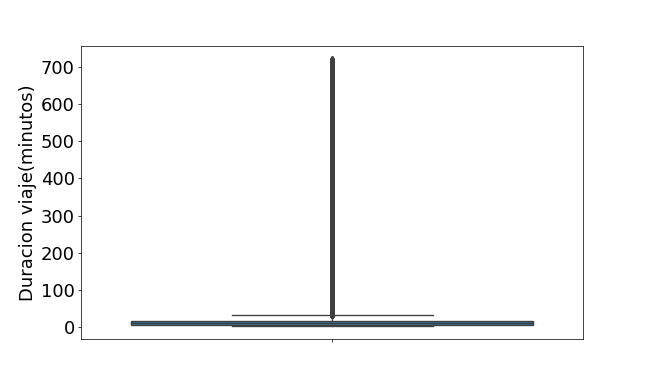

In [0]:
plt.figure(figsize = (10,6))
sns.boxplot("Duracion_viaje", data = dy3_new, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Duracion viaje(minutos)", fontsize = 20)
plt.show()

**13. Definimos una variable con el fin de  mostrar los valores contenido en los cuántiles.**

In [0]:
quantile_Duracion_viaje = dy3_new.Duracion_viaje.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

**14. Cuántiles de la duración del viaje. Se observa que no hay tiempos negativos y que el percentil 100 es demasiado mayor para ser real.**

In [0]:
qValues = np.round(np.arange(0.01, 1.01, 0.01), 2)
for i in qValues:
    print("{} Valor del percentil de la duracion del viaje: {}min".format((int(i*100)), quantile_Duracion_viaje[i]))

1 Valor del percentil de la duracion del viaje: 1.1666666666666667min
2 Valor del percentil de la duracion del viaje: 1.9166666666666667min
3 Valor del percentil de la duracion del viaje: 2.35min
4 Valor del percentil de la duracion del viaje: 2.683333333333333min
5 Valor del percentil de la duracion del viaje: 2.95min
6 Valor del percentil de la duracion del viaje: 3.2min
7 Valor del percentil de la duracion del viaje: 3.433333333333333min
8 Valor del percentil de la duracion del viaje: 3.6333333333333333min
9 Valor del percentil de la duracion del viaje: 3.8500000000000005min
10 Valor del percentil de la duracion del viaje: 4.033333333333333min
11 Valor del percentil de la duracion del viaje: 4.216666666666667min
12 Valor del percentil de la duracion del viaje: 4.4min
13 Valor del percentil de la duracion del viaje: 4.583333333333333min
14 Valor del percentil de la duracion del viaje: 4.75min
15 Valor del percentil de la duracion del viaje: 4.916666666666667min
16 Valor del percentil

**15. Dentro del dataset, se aplica un filtro según lo analizado anteriormente**


In [0]:
dy3_new = dy3_new[(dy3_new.Duracion_viaje>3) & (dy3_new.Duracion_viaje<720)]

**16. Plot para ver el cambio una vez realizado el filtro**

In [0]:
plt.figure(figsize = (10,6))
sns.boxplot("Duracion_viaje", data = dy3_new, orient = "v")
plt.ylim(ymin = 1, ymax = 750)
plt.tick_params(labelsize = 20)
plt.ylabel("Duracion viaje (minutos)", fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>

**17. Con esta visualización se aprecia la distribución de la duración del viaje. La gran mayoría de ellos no supera los 100 minutos.**

<IPython.core.display.Javascript object>


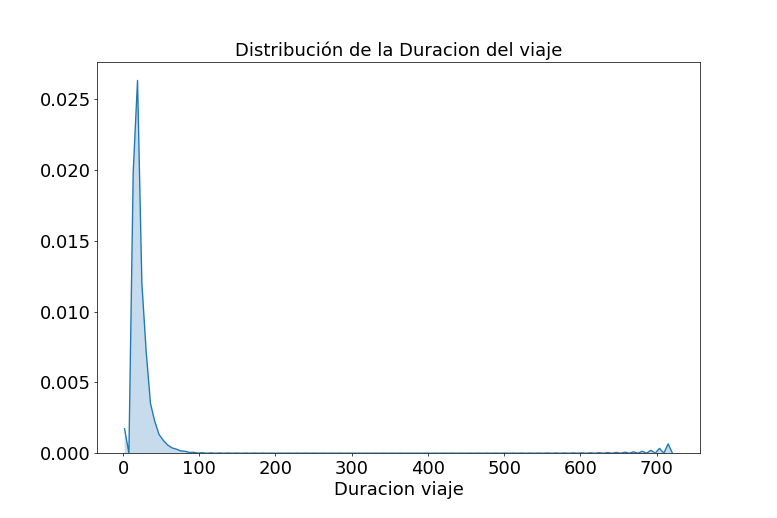

In [0]:
plt.figure(figsize = (12,8))
sns.kdeplot(dy3_new["Duracion_viaje"].values, shade = True, cumulative = False)
plt.tick_params(labelsize = 20)
plt.xlabel("Duracion viaje", fontsize = 20)
plt.title("Distribución de la Duracion del viaje", fontsize = 20)
plt.show()

In [0]:
dy3_new.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,Duracion_viaje,pickup_time,Velocidad
0,1,1.2,-73.990211,40.750969,-73.987892,40.738037,7.80,7.400000,1.425629e+09,9.729730
1,1,3.2,-73.935188,40.800720,-73.952553,40.765373,12.30,12.866667,1.425629e+09,14.922280
2,1,1.1,-73.963753,40.767937,-73.956947,40.780270,8.80,9.933333,1.425629e+09,6.644295
3,1,0.8,-73.997177,40.742168,-74.008064,40.739281,7.80,6.633333,1.425629e+09,7.236181
4,1,2.7,-74.006844,40.730267,-73.976860,40.750671,16.55,17.083333,1.425629e+09,9.482927


**18. Definimos una variable con el fin de  mostrar los valores contenido en los cuántiles.**

In [0]:
quantile_Velocidad = dy3_new.Velocidad.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

**19. Cuántiles de la velocidad del taxi durante el viaje. Se observa que no hay velocidades negativas y que el percentil 100 es demasiado mayor para ser real.**

In [0]:
qValues = np.round(np.arange(0.01, 1.01, 0.01), 2)
for i in qValues:
    print("{} Valor del percentil de la velocidad del viaje: {}millas/h".format((int(i*100)), quantile_Velocidad[i]))

1 Valor del percentil de la velocidad del viaje: 3.1304347826086953millas/h
2 Valor del percentil de la velocidad del viaje: 3.7344398340248963millas/h
3 Valor del percentil de la velocidad del viaje: 4.137931034482759millas/h
4 Valor del percentil de la velocidad del viaje: 4.460176991150443millas/h
5 Valor del percentil de la velocidad del viaje: 4.73037542662116millas/h
6 Valor del percentil de la velocidad del viaje: 4.968152866242039millas/h
7 Valor del percentil de la velocidad del viaje: 5.182341650671785millas/h
8 Valor del percentil de la velocidad del viaje: 5.381165919282511millas/h
9 Valor del percentil de la velocidad del viaje: 5.564068692206076millas/h
10 Valor del percentil de la velocidad del viaje: 5.736263736263736millas/h
11 Valor del percentil de la velocidad del viaje: 5.9016393442622945millas/h
12 Valor del percentil de la velocidad del viaje: 6.055890410958903millas/h
13 Valor del percentil de la velocidad del viaje: 6.206896551724138millas/h
14 Valor del percen

**20. Dentro del dataset, se aplica un filtro según lo analizado anteriormente**

In [0]:
dy3_new = dy3_new[(dy3_new.Velocidad>0) & (dy3_new.Velocidad<45)]

**21. Plot para ver el cambio una vez realizado el filtro**

<IPython.core.display.Javascript object>


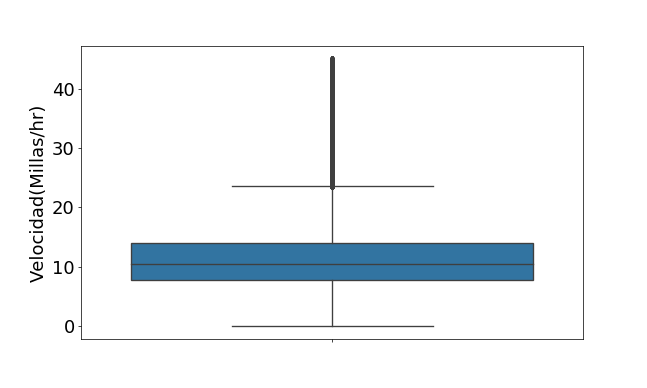

In [0]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("Velocidad", data = dy3_new, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Velocidad(Millas/hr)", fontsize = 20)
plt.show()

**22. Se realiza un cálculo para obtener la velocidad media de los taxis.**

In [0]:
Velocidad_media = sum(dy3_new.Velocidad)/len(dy3_new.Velocidad)
print("Velocidad media de los Taxis en NYC = "+str(Velocidad_media))

Velocidad media de los Taxis en NYC = 11.730527793967749


**23. Los taxis pueden viajar aproximadamente 2 millas en 10 minutos de media.**

In [0]:
dy3_new.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,Duracion_viaje,pickup_time,Velocidad
0,1,1.2,-73.990211,40.750969,-73.987892,40.738037,7.80,7.400000,1.425629e+09,9.729730
1,1,3.2,-73.935188,40.800720,-73.952553,40.765373,12.30,12.866667,1.425629e+09,14.922280
2,1,1.1,-73.963753,40.767937,-73.956947,40.780270,8.80,9.933333,1.425629e+09,6.644295
3,1,0.8,-73.997177,40.742168,-74.008064,40.739281,7.80,6.633333,1.425629e+09,7.236181
4,1,2.7,-74.006844,40.730267,-73.976860,40.750671,16.55,17.083333,1.425629e+09,9.482927


**24. Plot con la librería seaborn, de la duración del viaje. Esto nos sirve para una primera inspección de los valores.**

<IPython.core.display.Javascript object>


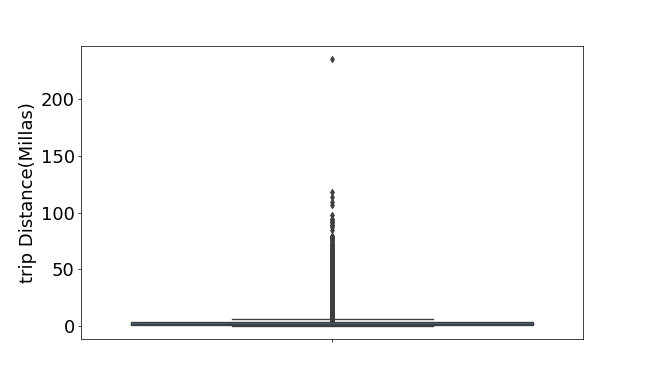

In [0]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = dy3_new, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("trip Distance(Millas)", fontsize = 20)
plt.show()

**25. Definimos una variable con el fin de  mostrar los valores contenido en los cuántiles.**


In [0]:
quantile_tripDistance = dy3_new.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

**26. Cuántiles de la distancia del viaje. Se observa que no hay distancias negativas y que el percentil 100 es demasiado mayor para ser real.**


In [0]:
qValues = np.round(np.arange(0.01, 1.01, 0.01), 2)
for i in qValues:
    print("{} Valor del percentil de la distancia del viaje: {}millas".format((int(i*100)), quantile_tripDistance[i]))

1 Valor del percentil de la distancia del viaje: 0.4millas
2 Valor del percentil de la distancia del viaje: 0.5millas
3 Valor del percentil de la distancia del viaje: 0.52millas
4 Valor del percentil de la distancia del viaje: 0.6millas
5 Valor del percentil de la distancia del viaje: 0.6millas
6 Valor del percentil de la distancia del viaje: 0.64millas
7 Valor del percentil de la distancia del viaje: 0.69millas
8 Valor del percentil de la distancia del viaje: 0.7millas
9 Valor del percentil de la distancia del viaje: 0.7millas
10 Valor del percentil de la distancia del viaje: 0.75millas
11 Valor del percentil de la distancia del viaje: 0.8millas
12 Valor del percentil de la distancia del viaje: 0.8millas
13 Valor del percentil de la distancia del viaje: 0.8millas
14 Valor del percentil de la distancia del viaje: 0.8399999999999999millas
15 Valor del percentil de la distancia del viaje: 0.89millas
16 Valor del percentil de la distancia del viaje: 0.9000000000000001millas
17 Valor del p

**27. Dentro del dataset, se aplica un filtro según lo analizado anteriormente**


In [0]:
dy3_new = dy3_new[(dy3_new.trip_distance>0) & (dy3_new.trip_distance<20)]

**28. Plot para ver el cambio una vez realizado el filtro**

<IPython.core.display.Javascript object>


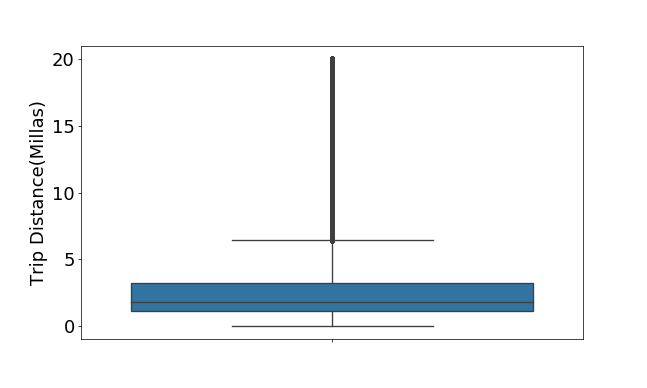

In [0]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = dy3_new, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Millas)", fontsize = 20)
plt.show()



**29. Plot con la librería seaborn, el precio del viaje. Esto nos sirve para una primera inspección de los valores.**

<IPython.core.display.Javascript object>


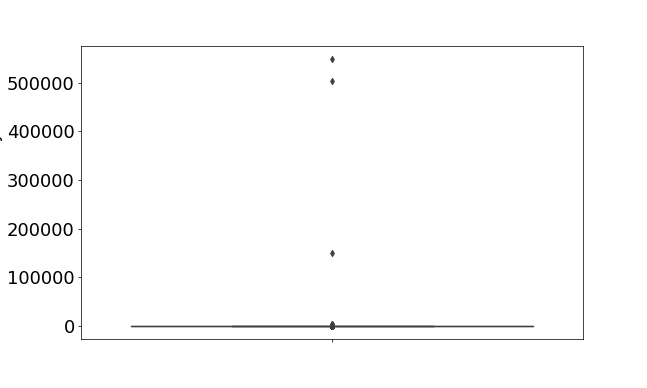

In [0]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = dy3_new, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Precio del viaje", fontsize = 20)
plt.show()

**30. Definimos una variable con el fin de  mostrar los valores contenido en los cuántiles.**


In [0]:
quantile_totalAmount = dy3_new.total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))


**31. Cuántiles del precio del viaje. Se observa que no hay precios negativos y que el percentil 100 es demasiado mayor para ser real.**


In [0]:
qValues = np.round(np.arange(0.01, 1.01, 0.01), 2)
for i in qValues:
    print("{} Valor del percentil del precio total del viaje: {}$".format((int(i*100)), quantile_totalAmount[i]))

1 Valor del percentil del precio total del viaje: 5.3$
2 Valor del percentil del precio total del viaje: 5.8$
3 Valor del percentil del precio total del viaje: 6.3$
4 Valor del percentil del precio total del viaje: 6.299999999999999$
5 Valor del percentil del precio total del viaje: 6.3$
6 Valor del percentil del precio total del viaje: 6.799999999999999$
7 Valor del percentil del precio total del viaje: 6.8$
8 Valor del percentil del precio total del viaje: 6.8$
9 Valor del percentil del precio total del viaje: 6.96$
10 Valor del percentil del precio total del viaje: 7.3$
11 Valor del percentil del precio total del viaje: 7.3$
12 Valor del percentil del precio total del viaje: 7.299999999999999$
13 Valor del percentil del precio total del viaje: 7.55$
14 Valor del percentil del precio total del viaje: 7.8$
15 Valor del percentil del precio total del viaje: 7.8$
16 Valor del percentil del precio total del viaje: 7.8$
17 Valor del percentil del precio total del viaje: 7.880000000000001$


**32. Dentro del dataset, se aplica un filtro según lo analizado anteriormente**


In [0]:
dy3_new = dy3_new[(dy3_new.total_amount>0) & (dy3_new.total_amount<67)]


**33. Filtro de las longitudes y latitudes de pickup**


In [0]:
dy3_new = dy3_new[(((dy3_new.pickup_latitude >= 40.5774) & (dy3_new.pickup_latitude <= 40.9176)) & ((dy3_new.pickup_longitude >= -74.15) & (dy3_new.pickup_longitude <= -73.7004)))]

**34. Filtro de longitudes y latitudes de dropoff**

In [0]:
dy3_new = dy3_new[(((dy3_new.dropoff_latitude >= 40.5774) & (dy3_new.dropoff_latitude <= 40.9176)) & ((dy3_new.dropoff_longitude >= -74.15) & (dy3_new.dropoff_longitude <= -73.7004)))]

**35. Se crean dos funciones. Una para la mínima distancia y la otra para la creación de las regiones. El parámetro de mínima distancia es tuneable, es el requerimiento que le damos para la creación de los clusteres.**

In [0]:
coord = dy3_new[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                
                distance = distance/(1.60934*1000)
                min_distance = min(min_distance, distance) 
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

**36. Ejecución del código anterior**

In [0]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time = "+str(datetime.now() - startTime))

Time = 0:02:27.229478


**37. Definición de variables para la posterior visualización de los resultados**

In [0]:
coord = dy3_new[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 20, batch_size = 10000).fit(coord)
dy3_new["Pickup_cluster"] = regions.predict(dy3_new[["pickup_latitude", "pickup_longitude"]])

**38. En esta visualización se ven los centros de los clusters que se han creado.**

In [0]:
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "OpenStreetMap")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

**39. En esta visualización se aprecian las regiones que hemos creado para el área de NYC. Hay un total de 20 regiones, parámetro que también se puede tunear.**

<IPython.core.display.Javascript object>


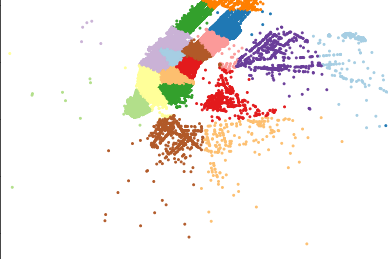

In [0]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = dy3_new.pickup_longitude.values[:70000], y = dy3_new.pickup_latitude.values[:70000], c = dy3_new.Pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Yellow Taxis Clustering de New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()